### Created By : Ashwini Kumar
### Dated : 8th August 2020
#### Objective : The idea of this project is to check out the feasibility of using recipes to identify similar food item. We will use sentence embeddings to get embedding for complete recipe and the calculate cosine similarity between them. 
#### Also, we will try to use community detection algorithms to identify communities of recipes maybe used for a lot of other purposes

#### Data Source : The source of data comes from food.com uploaded on kaggle which has recipes and recipes ratings csv


#### Import all the packages required for creating this algorithms 

In [8]:
import pandas as pd
import os 
import ast
import sentence_transformers  #### This is the package which we will use for encoding recipes using pretrained embedding
import matplotlib.pyplot as plt 
import networkx as nx #### Network x will be used to create graph based algorithms
import pickle ### We will use pickleto save files for later access
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity ### Cosine Similary
from scipy import sparse ### Sparse Matrix
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens') ### We will use this senetnce encodings

In [9]:
### Read the interactions csv as required 
interactions = pd.read_csv('RAW_interactions.csv')

print ("Lets look at the basic stats about the data")
print ("The shape of the data is")
print (interactions.shape)
print (" The columns in the data are as follows")
print (interactions.columns)
print (" The first few columns are ")
print (interactions.head(5))

Lets look at the basic stats about the data
The shape of the data is
(1132367, 5)
 The columns in the data are as follows
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')
 The first few columns are 
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  


In [10]:
interactions['rating'].value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

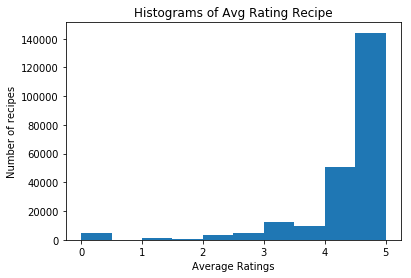

In [11]:
### Interestingly most of the recipes are rated at highest rating. 
interactions.groupby('recipe_id')['rating'].mean().reset_index().rating.plot(kind ='hist',title='Histograms of Avg Rating Recipe')
plt.xlabel("Average Ratings")
plt.ylabel("Number of recipes")
plt.show()



### We will restrict our analysis only to those recipes which has been reviewed by more than 2 people
### Analysis have shown that most recipes are only added but never seen

In [12]:
### Print for the poc purposes we will restrict
g = {'rating' : ['mean'],'user_id' : ['nunique']}
int_summary = interactions.groupby(['recipe_id']).agg(g).reset_index()
### Its gives a muti index output convert it to single index by cobining bothe level
ind = pd.Index([e[0] + "_" +e[1] for e in int_summary.columns.tolist()])
### Assign the column names 
int_summary.columns = ind
int_summary.columns = ['recipe_id', 'rating_mean', 'user_id_nunique']
### We will keep only those recipes in considerstaion which have been reviewed by more than 2 people
int_summary_94k = int_summary[ (int_summary['user_id_nunique'] > 2)]

### Read the recipes data and keep only data for recipes which are reviewed by more than 2 people

In [13]:
recipes = pd.read_csv('RAW_recipes.csv')
print (recipes.columns)

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


### Do the inner join with subset data

In [14]:
filter_recipe = pd.merge(recipes,int_summary_94k,right_on = ['recipe_id'],left_on = ['id'],how = 'inner')

In [15]:
filter_recipe

name      id  minutes  \
0             arriba   baked winter squash mexican style  137739       55   
1                       a bit different  breakfast pizza   31490       30   
2                                beat this  banana bread   75452       70   
3                          better than sex  strawberries   42198     1460   
4                        better then bush s  baked beans   67547     2970   
5                       chicken lickin  good  pork chops   63986      500   
6                                         chile rellenos   43026       45   
7                                         chinese  candy   23933       15   
8                                     chinese  chop suey    8559       70   
9                                 cream  of spinach soup   76808       45   
10                               crispy crunchy  chicken   83873       35   
11                       easiest ever  hollandaise sauce   49262       25   
12                      emotional balance  spice mixture   48156       10   
13                           fool the meat eaters  chili   54272       40   
14                                       fried  potatoes   37073       40   
15                 george s at the cove  black bean soup   44123       90   
16                                  grilled  ranch bread   93249       13   
17                              grilled  venison burgers   54100       26   
18                    healthy for them  yogurt popsicles   67664       10   
19     how i got my family to eat spinach  spinach ca...   25775       50   
20     i can t believe it s low fat  creamy potato salad   33165       30   
21                          i can t believe it s spinach   38798       30   
22          i don t feel like cooking tonight  casserole   22123       45   
23            i stole the idea from mirj  sesame noodles   90921       18   
24                 immoral  sandwich filling  loose meat   58224       35   
25                                        italian  fries   94710       15   
26                         jeanne s style  birthday cake   83025      230   
27                        jiffy  extra moist carrot cake   52804       50   
28            jiffy  roasted corn and jalapeno cornbread  108414       35   
29                 keep it going  german friendship cake   26995    14450   
...                                                  ...     ...      ...   
94534                                            zucotte   96811       65   
94535                                          zuke soup   73089       40   
94536                                       zulu cabbage  455000       40   
94537                          zuni caf zucchini pickles  316950     2895   
94538                                  zuni indian bread  223290      160   
94539                      zupas roasted red pepper soup  192796       45   
94540                         zupas summer chicken salad  192793       10   
94541                                     zuppa by luisa  464576       70   
94542                   zuppa di broccoli  broccoli soup   27801       18   
94543                     zuppa di cipolla al vino rosso  529308       60   
94544             zuppa di pesce  cioppino  or fish stew  116488       60   
94545  zuppa di pollo  italian chicken soup with past...  117910       30   
94546           zuppa di porcini  porcini mushrooms soup  245641       41   
94547  zuppa my weight watcher version of the olive g...  328409       70   
94548                    zuppa toscana from olive garden  388574       60   
94549                                 zuppa toscana soup  247963       35   
94550            zuppa toscana soup   olive garden clone  208429       60   
94551                            zupse bread swiss bread  115337      290   
94552                          zurie s chicken liver pat  195826       30   
94553       zurie s holey rustic olive and cheddar bread  267661       80   
94554                   zurie s overnight no kne

In [16]:
### The steps recipe is in list. We will combine list into one string
filter_recipe['dish_recipe'] = filter_recipe['steps'].apply(lambda x : " ".join(ast.literal_eval(x)))

In [18]:
#### We will encode the recipes and store it in pickle file
encodings_recipe= model.encode(filter_recipe['dish_recipe'])
pickle.dump(encodings_recipe,open("recipe_embedding.pickle",'wb'))

In [ ]:
# encodings_name = model.encode(filter_recipe['name'])

In [ ]:
# queries = ['melissas famous brownies']
# query_embeddings = model.encode(queries)

In [ ]:
# import scipy
# filter2 = filter_recipe.reset_index(drop = True)

# distances = cosine_similarity(query_embeddings.reshape(1,-1),encodings_name)
# filter2['dist'] = distances[0]
# filter2.sort_values(by = ['dist','name'],ascending=False,inplace = True)
# # print (filter2.head(2))
# print ("you much try these 5 dishes")
# print (filter2[['name','minutes','dist','ingredients']].head(5))
# for query, query_embedding in zip(queries, query_embeddings):
#     distances = cosine_similarity([query_embedding], encodings_name)
# filter_recipe['dist'] =distances[0]   
# filter_recipe.sort_values(by=['dist'],ascending = False,inplace = True)
# filter_recipe.head(5)

In [19]:
#### Load the pickle files of encoding and create a dataframe out of it
encodings_recipe_df = pickle.load(open("recipe_embedding.pickle",'rb'))
print ("Encoding are loaded")
data_encoding = pd.DataFrame(encodings_recipe_df)

Encoding are loaded


In [46]:
### As we don't have enough memory create cosine similary for only 5000 recipes
encoding_sparse = sparse.csr_matrix(encodings_recipe_df[0:10000])

In [47]:
# similarities = cosine_similarity(encoding_sparse)
# print('pairwise dense output:\n {}\n'.format(similarities))

#also can output sparse matrices
import datetime
time = datetime.datetime.now()
print (time)
similarities_sparse = cosine_similarity(encoding_sparse)
# print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
print ("Time taken is :",)
print (datetime.datetime.now()-time)

2020-08-07 16:25:27.211026
Time taken is :
0:04:29.041539


In [48]:
### Convert the pickle file to datafarme and dump
df1 = pd.DataFrame(similarities_sparse)
pickle.dump(df1,open('similarities_sparse.pickle','wb'))

In [49]:
data_similarity = df1.unstack().reset_index() 

In [50]:
data_similarity.columns = ['recipe1','recipe2','cosine_similarity']

In [51]:
data_similarity = data_similarity[data_similarity['cosine_similarity']<0.9999]

In [52]:
data_similarity.shape

(99989992, 3)

In [53]:
recipe_dict = {}
for j,i in enumerate(filter_recipe['name']):
    recipe_dict[j] = i
print ("Dictionary is created :")
    

Dictionary is created :


In [54]:
data_similarity['recipe1_name'] = data_similarity['recipe1'].map(recipe_dict)
data_similarity['recipe2_name'] = data_similarity['recipe2'].map(recipe_dict)

In [55]:
data_similarity.head(5)

recipe1  recipe2  cosine_similarity  \
1        0        1           0.545173   
2        0        2           0.655629   
3        0        3           0.640965   
4        0        4           0.597040   
5        0        5           0.570015   

                                 recipe1_name  \
1  arriba   baked winter squash mexican style   
2  arriba   baked winter squash mexican style   
3  arriba   baked winter squash mexican style   
4  arriba   baked winter squash mexican style   
5  arriba   baked winter squash mexican style   

                       recipe2_name  
1  a bit different  breakfast pizza  
2           beat this  banana bread  
3     better than sex  strawberries  
4   better then bush s  baked beans  
5  chicken lickin  good  pork chops

In [56]:
data_similarity['similarity_rank'] = data_similarity.groupby(['recipe1'])['cosine_similarity'].rank("dense", ascending=False)

In [57]:
data_similarity = data_similarity[data_similarity['similarity_rank'] <= 5].reset_index()

In [93]:
data_similarity.to_csv('test1.csv')

In [96]:
def find_similar_dishes(list_names):
    for i in list_names:
        dummy_data =  data_similarity[data_similarity['recipe1_name'] == i]
        print ("As you liked dish :",i)
        print ("You must try following 4 dishes with slight variations")
        dummy_data.sort_values(inplace = True,by =['similarity_rank']) 
        for j,i in enumerate(dummy_data['recipe2_name'].unique()):
            print ("             ", i)
            if j == 3:
                break

In [97]:
import warnings
warnings.filterwarnings('ignore')
find_similar_dishes(['banana walnut cake','aaloo mattar   indian style peas and potatoes','avocado ranch burgers with smoked cheddar',
                    'bird s perfect baked potatoes','bird s ultimate taco salad'])



As you liked dish : banana walnut cake
You must try following 4 dishes with slight variations
              banana snack cake with delicious cream cheese frosting
              anna banana s birthday cake with chocolate fudge icing
              baby food pineapple coconut carrot cake
              banana walnut buttermilk bread
As you liked dish : aaloo mattar   indian style peas and potatoes
You must try following 4 dishes with slight variations
              aloo gobi
              aloo mutter
              balti seitan madras
              aloo palak  indian potatoes   spinach
As you liked dish : avocado ranch burgers with smoked cheddar
You must try following 4 dishes with slight variations
              aussie lamb burgers with goat cheese and tomato relish
              apple butter barbecue burgers
              asian style hamburgers
              avocado beef burgers
As you liked dish : bird s perfect baked potatoes
You must try following 4 dishes with slight variations
     

In [59]:
G = nx.from_pandas_edgelist(data_similarity,'recipe1_name','recipe2_name')

In [64]:
data_sample = data_similarity
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(250,250))
plt.rcParams['axes.facecolor'] ='white'
G = nx.Graph()
for i in range(0,5000):
    G.add_edge(data_sample['recipe1_name'][i], data_sample['recipe2_name'][i], weight=data_sample['cosine_similarity'][i])

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.8]


pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=50)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=5)


# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.savefig("foo.pdf", bbox_inches='tight')
plt.axis('off')
plt.show()



In [65]:
import networkx.algorithms.community as nxcom
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
    # Count the communities
print(f"The karate club has {len(communities)} communities.")

The karate club has 72 communities.


In [66]:
for i in communities:
    print (i)

frozenset({'flaky  oatmeal raisin cookies', 'barefoot contessa s brownie tart', 'best no cook peanut butter fudge', '4 ingredient sugar cookies', 'best ever chocolate cake  from sorrento', 'no sausage     gravy for biscuits and gravy', 'alan jackson s chocolate cake and frosting', 'barefoot contessa s creamy cheddar grits', 'amarula cheesecake', 'barb s cinnamon rolls', 'don t eat the  yellow snowman cookies', 'leftover  rice pudding', 'apple apricot chutney', 'hershey s triple layer cheesecake', 'banana oatmeal cookies with banana frosting', '5 minute fudge', 'baked pumpkin donuts', '7 layer brownie ice cream cake', 'jeanne s style  birthday cake', 'best southern pound cake', 'a different chocolate eclair cake  dessert', 'apple honey dutch baby', '7 sins ice cream dessert', 'amusement park cornbread', 'bailey s creamy chocolate pudding', 'banana sour cream bars', 'amish gooey rhubarb rolls', 'banana chip bars', 'apricot almond bundt cake', 'austrian raspberry shortbread', '1960 origin

frozenset({'artichoke tomato bruschetta', 'amazing angel hair pasta with shrimp', 'almost guacamole', 'balsamic tomato and garlic pizza with walnuts', '3 cheese chicken enchiladas', 'ancho and chipotle mole', 'baked asparagus wrapped in prosciutto', 'baked vegetarian enchiladas', 'baked ziti casserole', '5 layer dip', 'awesome beef or chicken taco soup', '8 can taco soup', 'a b c  vegetable casserole', 'baked crab quesadillas appetizers', 'get up   go  bars', 'a true texan s king ranch chicken', 'a vegetarian finnish mashed potato casserole', 'avocado cheddar grilled cheese', 'another chicken parmesan   the one i like', 'baked mac n cheese', 'baked chicken and mushrooms', 'asparagus   cheese strata', 'best black bean enchiladas', 'baked spinach and eggs', 'berry blue cheese spread', 'basic cheese sauce', 'basic tahini sauce', 'lite  stuffed mushrooms', 'aussie swiss chicken', 'aunt darlene s macaroni   cheese', 'some like it hot', 'anasazi enchiladas', 'beef and broccoli', 'chile relle

frozenset({'100  whole wheat bread low fat and good', 'auntie s no bake cookies', 'amelie s salted caramel brownies', 'amish oatmeal whoopie pie cookies', 'banana cupcakes with amaretto buttercream', 'keep it going  german friendship cake', 'best wheat bread', '4 layer vanilla chocolate raspberry bars', 'baked apple fritters', 'basic quick pizza dough', 'the best  banana bread  or muffins', 'grilled  ranch bread', 'apple yogurt muffins', 'almost nutra grain bars', 'banana chocolate mini muffins', '100  whole grain wheat bread', 'apple and raspberry crumble  crisp', 'a new england holiday bread with olde world roots', 'babka', 'amish cinnamon buns 1994   indiana', 'banana cookies  with dates and nuts', 'barefoot contessa coconut cake and frosting   ina garten', 'berry cream muffins', 'amazing thin crust pizza', 'relatively  healthy cinnamon buns', '35 calorie pumpkin cookies', '90 minute bread', 'ann sather s cinnamon rolls', 'basic bagel  for the bread machine', 'all in one sponge cake

frozenset({'apricot gorgonzola crescent appetizers', 'barbara s tea cakes  cookies', 'banana crackers', 'big cookies', 'awesome easy chicken pot pie', '4 inch chocolate peanut butter cheesecake', 'awesome chocolate chip cookies', 'almond disaronno truffles', 'best ever chocolate cake   recipe', 'banana waffles with toasted pecans', 'big chewy oatmeal raisin cookies', 'barb s almond pound cake', 'apple pie squares', 'amerikaner   german vanilla biscuit', 'basic easy butter cake', 'betty s banana chocolate chunk cookies', 'apricot almond upside down cake', 'a quartet of english and french cheese flavoured butters', '100 good cookies', 'basic cookie mix', 'bedrock bars', 'apple syrup cake', 'sneaky  chocolate zucchini cupcakes kids love', 'banana cashew melt', 'banana chocolate chip cookies', 'a simple macaroon', 'apple gingerbread bread pudding', 'bed   breakfast scones', 'bailey s truffle fudge', '4 ingredient easy chocolate fudge', 'betty s crunchy brownie bars', 'banana pecan biscotti

frozenset({'4th of july grilled salmon  or chicken', 'baby artichoke gratin', 'baked broccoli frittata', 'asparagus fettuccine', 'aglio olio e peperoncino  garlic  oil and chilli pasta sauce', 'angel hair pasta with spinach  tomatoes and onion', '2bleu s white lasagna  lite bleu', '5 minute sherried shrimp tapas', 'baked pasta with sun dried tomatoes and ricotta cheese', 'my thai  chicken soup', 'baked cod with summer squash', 'no fuss  easy baked artichokes', '10 minute tomato sauce from america s test kitchen', 'billy s red  white  and bleu pasta', 'angel hair with avocado and tomatoes', 'al kabsa   ancient arabian chicken and fragrant rice', 'make that chicken dance  salsa pasta', 'artichokes chilled with champagne vinaigrette', 'authentic italian spaghetti sauce', 'african chicken peanut butter soup', '5 star gourmet sauce for steak', '5 minute spaghetti sauce', '20 minute easy ravioli  or tortellini bolognese', 'a cheaper cioppino', 'baked tilapia with veggies  herbs  and wine', '

frozenset({'missy s  sweet potato casserole', 'bacon cheddar potato soup', 'baked cajun fries', 'baked brie  potatoes  ham and eggs', 'baby baked potatoes with bleu cheese topping', 'awful  awful potatoes', 'better for you deviled eggs', 'baked goats cheese scallion mashed potatoes', 'autumn two potato scallop', 'basic home fries', 'asparagus and avocado wraps', 'baked yams with lime and honey', 'baby greens and garlicky white bean salad', 'avocado mashed potatoes', 'almost marzetti s slaw dressing', 'potatoes with garlic and cheese  pommes de terre a l ail', '10 minute low fat potato salad', 'bacon and blue cheese potato surprise', 'baked potatoes with shallot corn butter', '3 cheese potato casserole', 'kelly s creamy cheddar pea salad', 'amazing italian tomato soup', 'baked sweet potatoes with apricots and prunes', 'i can t believe it s low fat  creamy potato salad', 'baked potato salad', 'a mountain of make ahead mashed potatoes', 'asian sweet and spicy noodles  vegetarian', 'bahami

frozenset({'baked pork chops with roasted potatoes  parsnips and carrots', 'beef jerk burgers   caribbean', 'a real philly cheesesteak', 'bacon   goat cheese potatoes with sundried tomato sour cream', 'baked spinach dip loaf', 'barefoot contessa s lasagna', 'basa fillet with cajun veggies', 'baked sausage potatoes and cheese', 'authentic baked ziti', 'barbie s blt   a', 'baked tilapia with white wine and herbs', 'baked ziti and italian sausage', 'addicting cheesy potato casserole', 'armadillo eggs  stuffed jalapenos', 'beef and mushrooms', 'baked ham and cheese in a mashed potato crust', '10 minute tuscan tomato soup with parmesan toasts', 'baked chicken breasts w parmesan garlic crust', 'bacon and avocado sandwiches', 'best blts', 'baked chicken in parmesan and roasted garlic sauce', 'bbq sirloin steak supreme', 'baked cheese fries', 'artichoke brie dip', 'baked lasagne', '10 lb  lasagna', 'b l t  tossed salad', 'babette s colossal crockpot chili  ragu', 'bacon cheeseburger macaroni s

frozenset({'5 cup salad', '10 layer meat veggie and potato dish', 'banana s mores', 'african chicken in spicy red sauce', 'acadia s marinara sauce', '1 hour ham and bean soup', 'pour over anything  mushroom gravy', 'balsamic glazed baby onions', 'balsamic citrus pork chops', 'barbecue pork buns', 'baked sweet potatoes with brown sugar pecan butter', 'asian garlic sauce', 'basic cooked lima beans', 'asparagus fried rice', '25 clove garlic soup', 'cream  of mushroom soup', 'baked squash sticks', 'a different crock pot vegetable casserole', 'aunt annie s cheese ball', 'barefoot contessa s rosemary white bean soup', 'barbecued lima beans baked', 'azteca squash soup', 'baby food cake', 'best brown rice meal', '57 sauce with honey  for cocktail franks', 'bar  cheese', 'asian brown rice and peanut salad toss', 'bacon and horseradish dip', 'bill knapp s michigan bean soup', 'ancho chile pork chops', 'acadia s ratatouille', '3 bean casserole  bourbon beans', 'asian style honey vegetable stir fr

frozenset({'bacon and tomato grilled cheese sandwich', 'bacon avocado quesadillas', 'army rice', 'beer cheese fondue in sourdough round  rarebit in a hole', 'bbq stuffed jalapenos', 'amish baked noodles with ham', 'baked brie with pear topping', '24 hour omelet', 'beef pesto panini', 'baked grilled cheese', 'banana wheat waffles', '7 layer ham casserole', '3 cheese toasted sandwiches', 'beautiful burger buns', 'a fun and frolic kind of avocado  bacon  and tomato wrap yippee', 'mcgriddle  pancakes breakfast sandwich', 'asparagus grill sandwiches', 'baked asparagus spinach risotto', 'apple turkey burgers', 'baked egg and cheese sandwiches', 'big thick buttery roast beef  n cheddar sammies   sandwiches', 'better than boston market creamed spinach', 'bacon turkey bravo sandwich', 'bennigan s baked monte cristo sandwich', 'bacon  horseradish  and tomato sandwiches', '30 second sandwich', 'bacon biscuits', 'andrea spadoni s deluxe grilled cheese', '1 2 3 jambalaya', 'bacon monkey bread', 'be

frozenset({'afghan tomato  cucumber and onion salad  salata', 'balsamic cashew pea salad', 'apple salad with pomegranate molasses', 'asian american confetti', 'almond tahini date balls', 'pink stuff     cherry pie filling  pineapple dessert'})
frozenset({'tastes like   v 8 juice', 'basic fruit dip', 'bean and tomato salad', 'alli s renegade cocktail sauce', 'aunt meda s cranberry salad', 'best fruit smoothie ever'})
frozenset({'best carrot soup', 'baby carrot soup with cilantro and curry', 'autumn carrot soup', 'autumn bisque', 'baked winter squash soup', 'the bomb  pumpkin soup'})
frozenset({'beef medallions and mushrooms in red wine sauce', 'amish salisbury steak', 'the  creamed dried beef chipped beef recipe', 'beef patties with cream sauce', 'beef stroganoff  with make ahead directions', 'amish  mennonite dried beef gravy mmmmmmmm'})
frozenset({'call the fire department  hot wings', 'bernice s bat wings with swamp dip', 'another buffalo wings recipe', 'big brothers chicken wings', 

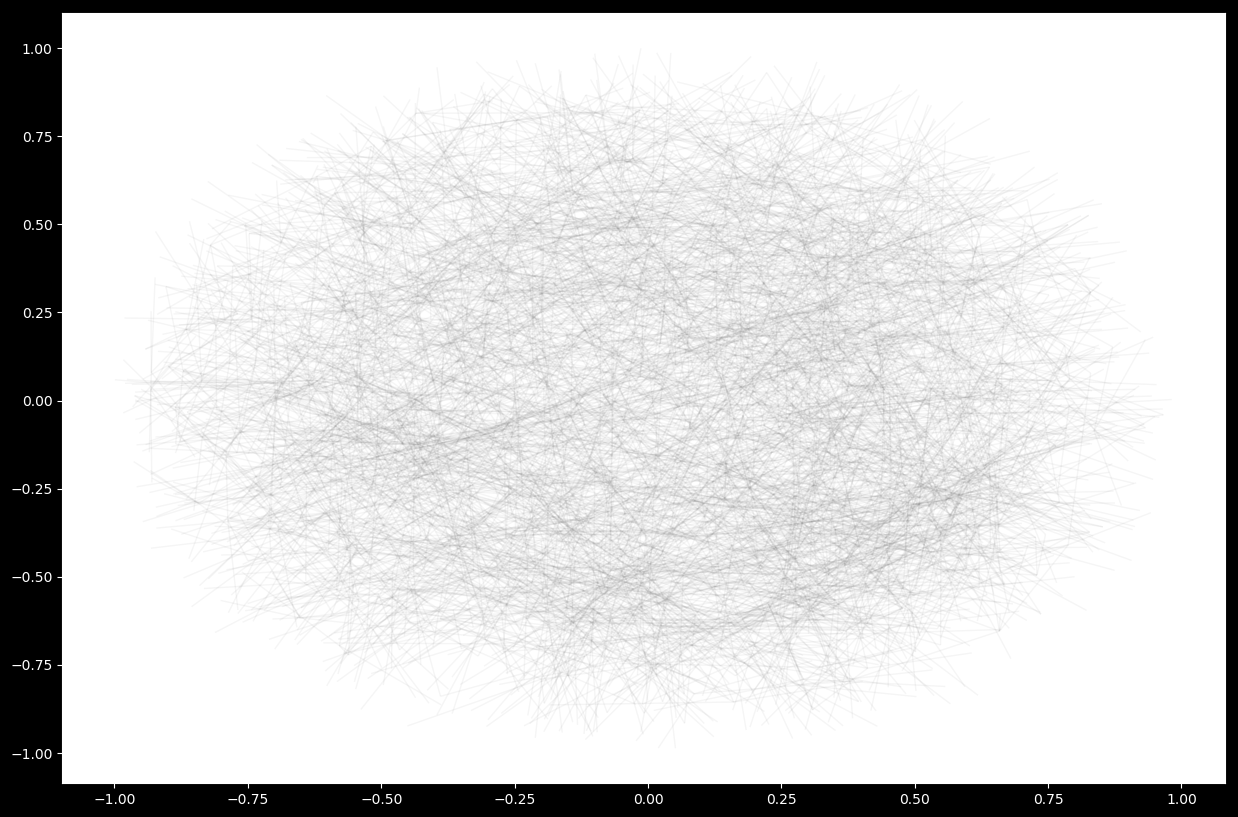

In [67]:
pos = nx.spring_layout(G, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=0, 
    edge_color="#444444", 
    alpha=0.05, 
    with_labels=False)

In [68]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
len(communities)

72

In [69]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)          

C:\Users\ashwinku\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


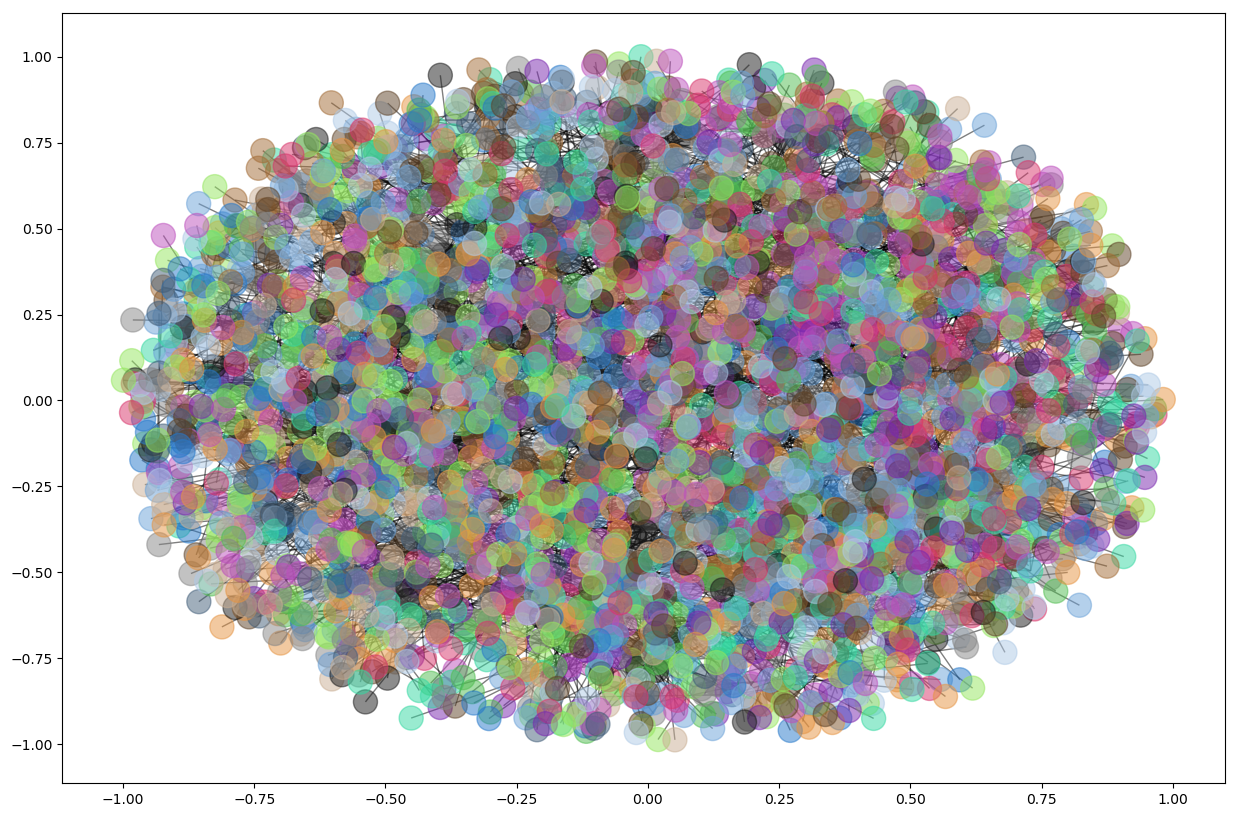

In [72]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})


# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

# Set community color for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
# external edges
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=0, 
    edgelist=external, 
    edge_color="silver",
    node_color=node_color,
    alpha=0.2, 
    with_labels=False)
# internal edges
nx.draw_networkx(
    G, pos=pos, 

    edgelist=internal, 
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.5, 
    with_labels=False)